In [1]:
def get_environment():
    try:
        # Check if the environment is Google Colab
        import google.colab
        return "colab"
    except ImportError:
        # Environment is not Google Colab, assume it is local
        return "local"

environment = get_environment()

if environment == "colab":
    colab_path = "/content/drive/MyDrive/Colab Notebooks/"
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install finance-datareader
elif environment == "local":
    colab_path = ""

함수 import

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from scipy import stats
from scipy.optimize import minimize

from datetime import timedelta

# Neural Network library
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow import keras
from tensorflow.python.keras.models import load_model
from keras import callbacks
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

import matplotlib.pyplot as plt
plt.style.use("bmh")

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
plt.rc('font', family='Pretendard') # For Windows
%matplotlib inline

MV 모델 벤치마크

In [3]:
def calc_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return portfolio_std

def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

def calc_portfolio_VaR(weights, mean_returns, cov, alpha):
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var

def portfolio_optimization_std(w, r, cov):
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    args = (r, cov)
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(len(w)))
    optimization_result = minimize(calc_portfolio_std, w, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimization_result

def portfolio_optimization_sharpe(w, r, cov, rf):
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    args = (r, cov, rf)
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(len(w)))
    optimization_result = minimize(calc_neg_sharpe, w, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimization_result

def portfolio_optimization_Var(w, r, cov, alpha):
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    args = (r, cov, alpha)
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(len(w)))
    optimization_result = minimize(calc_portfolio_VaR, w, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return optimization_result

## 2002-01-01 부터 학습하여 2018년 이후의 백테스트

In [16]:
df = pd.read_csv(colab_path + "0526_data.csv", index_col="Date")
df

,CSI300,KOSDAQ,KOSPI,KOSPI-Short,MMF,Nikkei225,S&P500,STOXX50,US-Long,US-Short,WTI,국채10년,금,우량회사채,해외채권
Date,,,,,,,,,,,,,,,
2015-10-14,0.032716,-0.012458,-0.004400,-0.000609,0.000196,-0.013886,-0.009577,-0.010408,-0.009589,0.009246,-0.058099,-0.002759,0.030457,-0.000144,-0.004830
2015-10-15,0.023419,0.008163,0.011972,-0.013489,0.000196,0.011443,0.014744,0.014693,-0.013072,0.013711,-0.005590,0.005052,0.006588,0.000914,0.002359
2015-10-16,0.013460,0.014717,-0.002100,0.001850,0.000000,0.010712,0.004560,0.008032,-0.001699,0.001814,0.018796,-0.000542,-0.003626,-0.000577,0.004584
2015-10-19,0.000031,-0.000943,0.000404,0.001847,0.000049,-0.008817,0.000271,0.002175,-0.007682,0.009021,-0.029417,-0.000750,-0.008740,0.000240,0.002694
2015-10-21,-0.017391,0.005644,0.007167,-0.007407,-0.000196,0.023065,-0.007265,0.000058,0.008957,-0.010835,-0.015150,-0.003592,-0.004870,0.000000,-0.000118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-19,-0.003955,0.000791,0.023063,-0.022716,0.000097,0.023474,0.007954,0.016533,-0.006254,0.007301,-0.017731,-0.007095,-0.001010,-0.001244,0.001618
2023-05-22,0.006265,0.018019,0.006085,-0.007688,0.000000,0.008998,0.000155,-0.002202,-0.005943,0.006137,0.006131,0.002058,-0.001973,0.000191,0.004438
2023-05-23,-0.014244,0.011195,0.002436,-0.001103,0.000097,-0.004160,-0.011285,-0.009911,-0.004921,0.005546,0.012699,-0.005916,-0.001216,-0.000096,-0.005247


In [5]:
df = pd.read_csv(colab_path + "0526_data.csv", index_col="Date")
train, test = train_test_split(df, test_size=0.2, shuffle=False)

train_len = len(train)
test_len = len(test)
validation_set_len = 65
validation_set_split_point = 60
future_set_len = 5
N_STOCKS = 15

xc_train = np.empty((train_len - validation_set_len, validation_set_split_point, N_STOCKS))
xf_train = np.empty((train_len - validation_set_len, future_set_len, N_STOCKS))
xc_test = np.empty((test_len - validation_set_len, validation_set_split_point, N_STOCKS))
xf_test = np.empty((test_len - validation_set_len, future_set_len, N_STOCKS))

for idx in range(train_len - validation_set_len):
    temp_xc_train = train[idx : idx + validation_set_split_point]
    temp_xf_train = train[idx + validation_set_split_point : idx + validation_set_len]

    xc_train[idx] = temp_xc_train
    xf_train[idx] = temp_xf_train

for idx in range(test_len - validation_set_len):
    temp_xc_test = test[idx : idx + validation_set_split_point]
    temp_xf_test = test[idx + validation_set_split_point : idx + validation_set_len]

    xc_test[idx] = temp_xc_test
    xf_test[idx] = temp_xf_test
    
# 월간 수익률 정도의 스케일로 변환한다
xc_train = xc_train.astype('float32') * 5
xf_train = xf_train.astype('float32') * 5
xc_test = xc_test.astype('float32') * 5
xf_test = xf_test.astype('float32') * 5

N_TIME = xc_train.shape[1]
N_FUTURE = xf_train.shape[1]
N_STOCKS = xf_train.shape[2]

# 학습 데이터는 shuffling 한다.
xc_train, xf_train = shuffle(xc_train, xf_train)

In [6]:
# over confidence를 제어할 조절 변수 정의
GAMMA_CONST = 0.1
REG_CONST = 0.0

# 최적 포트폴리오를 구축할 목표 함수를 정의한다.
# MPN에서는 이 함수를 loss로 이용한다. max(objective) = min(-objective)
# y_true = model.fit()에서 전달된 N_FUTURE일 후의 수익률 (xf_train)이 들어온다.
# y_pred = 마코비츠 네트워크의 출력이 전달된다. (keras 내부 기능)

def markowitz_objective(y_true, y_pred):
    W = y_pred      # 마코비츠 네트워크의 출력
    xf_rtn = y_true
    W = tf.expand_dims(W, axis = 1)
    R = tf.expand_dims(tf.reduce_mean(xf_rtn, axis = 1), axis = 2)
    C = tfp.stats.covariance(xf_rtn, sample_axis=1)

    rtn = tf.matmul(W, R)  
    vol = tf.matmul(W, tf.matmul(C, tf.transpose(W, perm = [0, 2, 1]))) * GAMMA_CONST
    reg = tf.reduce_sum(tf.square(W), axis = -1) * REG_CONST
    objective = rtn - vol - reg
    
    return -tf.reduce_mean(objective, axis=0)

# LSTM으로 Markowitz 모델을 생성한다.
xc_input = tf.keras.Input(batch_shape = (None, N_TIME, N_STOCKS))
h_lstm = LSTM(64, dropout = 0.5, kernel_regularizer=l2(0.005))(xc_input)
y_output = Dense(N_STOCKS, activation='relu')(h_lstm)  # linear projection

# 마코비츠의 최적 weights
y_output = Activation('softmax')(y_output)
model = tf.keras.Model(xc_input, y_output)

prophet이 계속 학습하면 계속 Loss가 줄어듦으로 에포크를 500으로 통일 제한한다.

In [7]:
# MPN을 학습하고 결과를 저장한다.
SAVE_MODEL = 'Markowitz_network_final'
ealry_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.compile(loss = markowitz_objective, optimizer = Adam(learning_rate = 1e-5))
hist = model.fit(xc_train, xf_train, epochs=500, batch_size = 32, validation_data = (xc_test, xf_test), callbacks=[ealry_stopping], verbose=False)
model.save(SAVE_MODEL + '.h5')

Epoch 1/500
38/38 [==============================] - 4s 42ms/step - loss: 0.1402 - val_loss: 0.1414
Epoch 2/500
38/38 [==============================] - 1s 24ms/step - loss: 0.1392 - val_loss: 0.1403
Epoch 3/500
38/38 [==============================] - 1s 24ms/step - loss: 0.1381 - val_loss: 0.1393
Epoch 4/500
38/38 [==============================] - 1s 23ms/step - loss: 0.1370 - val_loss: 0.1382
Epoch 5/500
38/38 [==============================] - 1s 23ms/step - loss: 0.1360 - val_loss: 0.1372
Epoch 6/500
38/38 [==============================] - 1s 23ms/step - loss: 0.1349 - val_loss: 0.1361
Epoch 7/500
38/38 [==============================] - 1s 23ms/step - loss: 0.1339 - val_loss: 0.1351
Epoch 8/500
38/38 [==============================] - 1s 24ms/step - loss: 0.1328 - val_loss: 0.1341
Epoch 9/500
38/38 [==============================] - 1s 24ms/step - loss: 0.1318 - val_loss: 0.1330
Epoch 10/500
38/38 [==============================] - 1s 23ms/step - loss: 0.1308 - val_loss: 0.1320

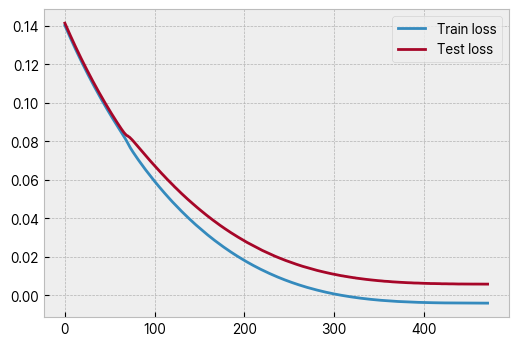

1/1 [==============================] - 0s 406ms/step


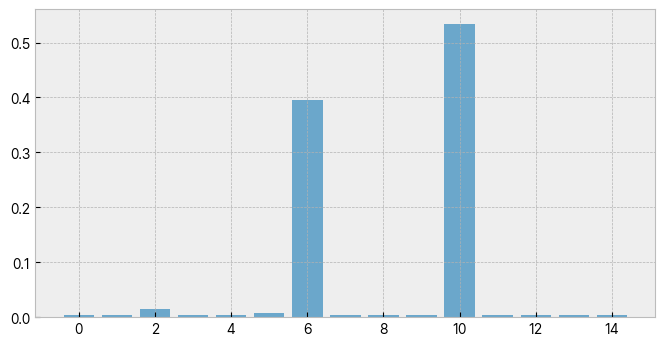

In [8]:
# loss trajectory를 확인한다.
plt.figure(figsize=(6, 4))
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend()
plt.show()

# 최적 포트폴리오 결과 조회용 코드
def check_w(n = 0):
    plt.figure(figsize=(8, 4))
    y_pred = model.predict(xc_test[n].reshape(1, N_TIME, N_STOCKS))[0]
    plt.bar(np.arange(N_STOCKS), y_pred, alpha = 0.7)
    plt.show()

check_w(0)

In [11]:
N_TIME = xc_test.shape[1]
N_FUTURE = xf_test.shape[1]
N_STOCKS = xf_test.shape[2]

# 저장된 Markowitz 모델을 가져온다.
SAVE_MODEL = 'Markowitz_network_final.h5'
model = load_model(SAVE_MODEL, compile = True, custom_objects={'markowitz_objective': markowitz_objective})
model.summary()

# 백 테스트를 수행한다.
prt_value = [10000]   # portfolio의 초기 value
crp_value = [10000]   # CRP의 초기 value
mvstd_value = [10000]    # MV_std의 초기 value
mvshp_value = [10000] # MV_sharpe의 초기 value
mvVaR_value = [10000] # MV_VaR의 초기 value
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)

w_history = []
w_history_std = []
w_history_shp = []
w_history_VaR = []
for i in range(0, xc_test.shape[0], N_FUTURE):
   
    # 이 시점에 각 종목을 w_prt 비율대로 매수한다.
    # 학습할 때 월간 수익률로 변환했으므로, 여기서도 변환해야 한다.
    x = xc_test[i][np.newaxis,:,:] * 5
    w_prt = model.predict(x)[0]
    w_history.append(w_prt)
    
    # 추가 코드
    x_mean = np.mean(x[0], axis=0)
    x_cov = np.cov(x[0].T)
    
    result_std = portfolio_optimization_std(w_crp, x_mean, x_cov)
    w_std = np.array([round(x,3) for x in result_std['x']])
    
    result_sharpe = portfolio_optimization_sharpe(w_crp, x_mean, x_cov, 0)
    w_shp = np.array([round(x,3) for x in result_sharpe['x']])
    
    result_VaR = portfolio_optimization_sharpe(w_crp, x_mean, x_cov, 0.05)
    w_VaR = np.array([round(x,3) for x in result_VaR['x']])
    
    w_history_std.append(w_std)
    w_history_shp.append(w_shp)
    w_history_VaR.append(w_VaR)

    # 다음 기간의 누적 수익률
    m_rtn = np.sum(xf_test[i], axis = 0) / 5
 
    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    prt_value.append(prt_value[-1] * np.exp(np.dot(w_prt, m_rtn)))
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))
    
    mvstd_value.append(mvstd_value[-1] * np.exp(np.dot(w_std, m_rtn)))
    mvshp_value.append(mvshp_value[-1] * np.exp(np.dot(w_shp, m_rtn)))
    mvVaR_value.append(mvVaR_value[-1] * np.exp(np.dot(w_VaR, m_rtn)))

    # 추가로 발생한 시장 데이터로 MPN을 추가 학습시킨다.
    # xc_test[0] ~ xc_test[19],
    # xf_test[0] ~ xf_test[19]를 추가로 학습시킬 수 있다.
    xc_new = xc_test[i:(i+N_FUTURE), :, :]
    xf_new = xf_test[i:(i+N_FUTURE), :, :]

    # xc_train 데이터에서 80개를 random sampling 한다.
    idx = np.random.randint(0, xc_train.shape[0], 65)

    # 추가 학습 데이터를 생성한다.
    x = np.vstack([xc_new, xc_train[idx]])
    y = np.vstack([xf_new, xf_train[idx]])
    x, y = shuffle(x, y)

    # 추가 학습한다.
    x *= 5.0
    y *= 5.0
    model.fit(x, y, epochs=50, batch_size=10, verbose=0)

    # 추가로 발생한 데이터도 이후에 sampling될 수 있도록 보관해 둔다.
    xc_train = np.vstack([xc_train, xc_new])
    xf_train = np.vstack([xf_train, xf_new])

# 평가 시점의 날짜를 발췌한다.
idx = np.arange(0, xc_test.shape[0] + 5, N_FUTURE)

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value, 'MV_Std':mvstd_value, 'MV_Max_Shp':mvshp_value, 'MV_VaR':mvVaR_value})

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 15)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20480     
_________________________________________________________________
dense (Dense)                (None, 15)                975       
_________________________________________________________________
activation (Activation)      (None, 15)                0         
Total params: 21,455
Trainable params: 21,455
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.save(SAVE_MODEL + 'AdLearning.h5')

In [13]:
perf_df

,crp,markowitz,MV_Std,MV_Max_Shp,MV_VaR
0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
1,9867.214083,9656.260610,9993.198882,10042.235201,9585.894897
2,9935.446736,9728.143197,10004.035933,9916.524263,9311.031195
3,10029.411672,10085.559286,10003.193383,9966.851761,10298.372776
4,9937.212241,9916.712954,9991.080563,9923.780957,8975.587552
5,9818.123994,9653.946792,9978.675318,9941.746804,9095.840819
6,9857.481636,9696.074446,9985.341649,9949.493012,9384.267798
7,9752.216152,9580.018374,9989.892066,9957.326094,9526.220774
8,9662.904822,9443.595803,9991.481752,9964.684523,9990.054112
9,9706.386334,9466.063808,9989.437866,9961.853259,10237.794222


<Axes: >

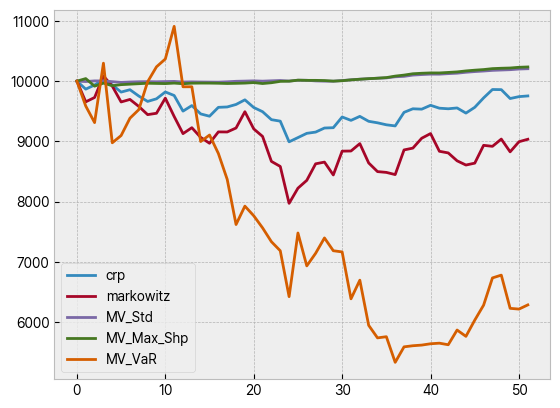

In [15]:
perf_df.plot()

---

## 2005년부터 2022년까지 학습, 2002년~2005년 테스트

In [4]:
df = pd.read_csv(colab_path + "top50-Stock_LogReturn.csv", index_col="Date")
train, test = df[1053:], df[:1053]

train_len = len(train)
test_len = len(test)
validation_set_len = 80
validation_set_split_point = 60

xc_train = np.empty((train_len - validation_set_len, 60, 50))
xf_train = np.empty((train_len - validation_set_len, 20, 50))
xc_test = np.empty((test_len - validation_set_len, 60, 50))
xf_test = np.empty((test_len - validation_set_len, 20, 50))

for idx in range(train_len - validation_set_len):
    temp_xc_train = train[idx : idx + validation_set_split_point]
    temp_xf_train = train[idx + validation_set_split_point : idx + validation_set_len]

    xc_train[idx] = temp_xc_train
    xf_train[idx] = temp_xf_train

for idx in range(test_len - validation_set_len):
    temp_xc_test = test[idx : idx + validation_set_split_point]
    temp_xf_test = test[idx + validation_set_split_point : idx + validation_set_len]

    xc_test[idx] = temp_xc_test
    xf_test[idx] = temp_xf_test
    
# 월간 수익률 정도의 스케일로 변환한다
xc_train = xc_train.astype('float32') * 20
xf_train = xf_train.astype('float32') * 20
xc_test = xc_test.astype('float32') * 20
xf_test = xf_test.astype('float32') * 20

N_TIME = xc_train.shape[1]
N_FUTURE = xf_train.shape[1]
N_STOCKS = xf_train.shape[2]

# 학습 데이터는 shuffling 한다.
xc_train, xf_train = shuffle(xc_train, xf_train)
test_len, train_len - validation_set_len

(1053, 4132)

In [ ]:
# LSTM으로 Markowitz 모델을 생성한다.
xc_input = tf.keras.Input(batch_shape = (None, N_TIME, N_STOCKS))
h_lstm = LSTM(64, dropout = 0.2, kernel_regularizer=l2(0.01))(xc_input)
y_output = Dense(N_STOCKS, activation='tanh')(h_lstm)  # linear projection

# 특정 종목을 과도하게 매수하는 것을 방지하기 위해 위에서 tanh를 사용했다. 
# (over confidence 방지용). REG_CONST를 적용했기 때문에 이미 고려된 사항이지만, 
# 안전을 위해 추가했다. ex : [-3, 0.4, 0.2, +20] --> [-0.995, 0.380, 0.197, 1.0]|

# 마코비츠의 최적 weights
y_output = Activation('softmax')(y_output)
model = tf.keras.Model(xc_input, y_output)

In [ ]:
from keras import callbacks
# # MPN을 학습하고 결과를 저장한다.
SAVE_MODEL = 'Markowitz_network_CV_final'
ealry_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.compile(loss = markowitz_objective, optimizer = Adam(learning_rate = 1e-6))
hist = model.fit(xc_train, xf_train, epochs=500, batch_size = 32, validation_data = (xc_test, xf_test), callbacks=[ealry_stopping])
model.save(SAVE_MODEL + '.h5')

In [ ]:
# loss trajectory를 확인한다.
plt.figure(figsize=(6, 4))
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend()
plt.show()

# 최적 포트폴리오 결과 조회용 코드
def check_w(n = 0):
    plt.figure(figsize=(8, 4))
    y_pred = model.predict(xc_test[n].reshape(1, N_TIME, N_STOCKS))[0]
    plt.bar(np.arange(N_STOCKS), y_pred, alpha = 0.7)
    plt.show()

check_w(0)

In [ ]:
N_TIME = xc_test.shape[1]
N_FUTURE = xf_test.shape[1]
N_STOCKS = xf_test.shape[2]

# 저장된 Markowitz 모델을 가져온다.
SAVE_MODEL = 'Markowitz_network_final.h5AdLearning.h5'
model = load_model(SAVE_MODEL, compile = True, custom_objects={'markowitz_objective': markowitz_objective})
model.summary()

# 백 테스트를 수행한다.
prt_value = [10000]   # portfolio의 초기 value
crp_value = [10000]   # CRP의 초기 value
mvstd_value = [10000]    # MV_std의 초기 value
mvshp_value = [10000] # MV_sharpe의 초기 value
mvVaR_value = [10000] # MV_VaR의 초기 value
w_crp = np.ones(N_STOCKS) / N_STOCKS   # CRP 비율 (균등 비율)

w_history = []
w_history_std = []
w_history_shp = []
w_history_VaR = []
for i in range(0, xc_test.shape[0], N_FUTURE):
   
    # 이 시점에 각 종목을 w_prt 비율대로 매수한다.
    # 학습할 때 월간 수익률로 변환했으므로, 여기서도 변환해야 한다.
    x = xc_test[i][np.newaxis,:,:] * 20
    w_prt = model.predict(x)[0]
    w_history.append(w_prt)
    
    # 추가 코드
    x_mean = np.mean(x[0], axis=0)
    x_cov = np.cov(x[0].T)
    
    result_std = portfolio_optimization_std(w_crp, x_mean, x_cov)
    w_std = np.array([round(x,3) for x in result_std['x']])
    
    result_sharpe = portfolio_optimization_sharpe(w_crp, x_mean, x_cov, 0)
    w_shp = np.array([round(x,3) for x in result_sharpe['x']])
    
    result_VaR = portfolio_optimization_sharpe(w_crp, x_mean, x_cov, 0.05)
    w_VaR = np.array([round(x,3) for x in result_VaR['x']])
    
    w_history_std.append(w_std)
    w_history_shp.append(w_shp)
    w_history_VaR.append(w_VaR)

    # 다음 기간의 누적 수익률
    m_rtn = np.sum(xf_test[i], axis = 0) / 20
 
    # 누적 수익률과 w_prt (W)로 포트폴리오의 수익률을 계산한다.
    prt_value.append(prt_value[-1] * np.exp(np.dot(w_prt, m_rtn)))
    crp_value.append(crp_value[-1] * np.exp(np.dot(w_crp, m_rtn)))
    
    mvstd_value.append(mvstd_value[-1] * np.exp(np.dot(w_std, m_rtn)))
    mvshp_value.append(mvshp_value[-1] * np.exp(np.dot(w_shp, m_rtn)))
    mvVaR_value.append(mvVaR_value[-1] * np.exp(np.dot(w_VaR, m_rtn)))

    # 추가로 발생한 시장 데이터로 MPN을 추가 학습시킨다.
    # xc_test[0] ~ xc_test[19],
    # xf_test[0] ~ xf_test[19]를 추가로 학습시킬 수 있다.
    xc_new = xc_test[i:(i+N_FUTURE), :, :]
    xf_new = xf_test[i:(i+N_FUTURE), :, :]

    # xc_train 데이터에서 80개를 random sampling 한다.
    idx = np.random.randint(0, xc_train.shape[0], 80)

    # 추가 학습 데이터를 생성한다.
    x = np.vstack([xc_new, xc_train[idx]])
    y = np.vstack([xf_new, xf_train[idx]])
    x, y = shuffle(x, y)

    # 추가 학습한다.
    x *= 20.0
    y *= 20.0
    model.fit(x, y, epochs=50, batch_size=10, verbose=0)

    # 추가로 발생한 데이터도 이후에 sampling될 수 있도록 보관해 둔다.
    xc_train = np.vstack([xc_train, xc_new])
    xf_train = np.vstack([xf_train, xf_new])

# 평가 시점의 날짜를 발췌한다.
idx = np.arange(0, xc_test.shape[0] + 20, N_FUTURE)

# 벤치마크를 위한 S&P500 정의
us500 = fdr.DataReader('US500', '2002-01-01', '2022-12-01')\
    ['Adj Close'][1:993][idx]
us500_value = us500 / us500[0] * 10000

# Markowitz 성과와 CRP 성과를 데이터 프레임에 기록해 둔다.
perf_df = pd.DataFrame({'crp':crp_value, 'markowitz':prt_value, 'MV_Std':mvstd_value, 'MV_Max_Shp':mvshp_value, 'MV_VaR':mvVaR_value,'S&P500':us500_value})

In [ ]:
model.save(SAVE_MODEL + 'AdLearning.h5')

## 예언자 Prophet 학습

In [5]:
df = pd.read_csv(colab_path + "top50-Stock_LogReturn.csv", index_col="Date")
train, test = df, train_test_split(df, test_size=0.2, shuffle=False)[1]

train_len = len(train)
test_len = len(test)
validation_set_len = 80
validation_set_split_point = 60

xc_train = np.empty((train_len - validation_set_len, 60, 50))
xf_train = np.empty((train_len - validation_set_len, 20, 50))
xc_test = np.empty((test_len - validation_set_len, 60, 50))
xf_test = np.empty((test_len - validation_set_len, 20, 50))

for idx in range(train_len - validation_set_len):
    temp_xc_train = train[idx : idx + validation_set_split_point]
    temp_xf_train = train[idx + validation_set_split_point : idx + validation_set_len]

    xc_train[idx] = temp_xc_train
    xf_train[idx] = temp_xf_train

for idx in range(test_len - validation_set_len):
    temp_xc_test = test[idx : idx + validation_set_split_point]
    temp_xf_test = test[idx + validation_set_split_point : idx + validation_set_len]

    xc_test[idx] = temp_xc_test
    xf_test[idx] = temp_xf_test
    
# 월간 수익률 정도의 스케일로 변환한다
xc_train = xc_train.astype('float32') * 20
xf_train = xf_train.astype('float32') * 20
xc_test = xc_test.astype('float32') * 20
xf_test = xf_test.astype('float32') * 20

N_TIME = xc_train.shape[1]
N_FUTURE = xf_train.shape[1]
N_STOCKS = xf_train.shape[2]

# 학습 데이터는 shuffling 한다.
xc_train, xf_train = shuffle(xc_train, xf_train)
test_len, train_len - validation_set_len

(1053, 5185)

In [ ]:
# LSTM으로 Markowitz 모델을 생성한다.
xc_input = tf.keras.Input(batch_shape = (None, N_TIME, N_STOCKS))
h_lstm = LSTM(64, dropout = 0.2, kernel_regularizer=l2(0.01))(xc_input)
y_output = Dense(N_STOCKS, activation='tanh')(h_lstm)  # linear projection

# 특정 종목을 과도하게 매수하는 것을 방지하기 위해 위에서 tanh를 사용했다. 
# (over confidence 방지용). REG_CONST를 적용했기 때문에 이미 고려된 사항이지만, 
# 안전을 위해 추가했다. ex : [-3, 0.4, 0.2, +20] --> [-0.995, 0.380, 0.197, 1.0]|

# 마코비츠의 최적 weights
y_output = Activation('softmax')(y_output)
model = tf.keras.Model(xc_input, y_output)

# # MPN을 학습하고 결과를 저장한다.
SAVE_MODEL = 'prophet'
ealry_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.compile(loss = markowitz_objective, optimizer = Adam(learning_rate = 1e-6))
hist = model.fit(xc_train, xf_train, epochs=500, batch_size = 32, validation_data = (xc_test, xf_test), callbacks=[ealry_stopping])
model.save(SAVE_MODEL + '.h5')

# loss trajectory를 확인한다.
plt.figure(figsize=(6, 4))
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Test loss')
plt.legend()
plt.show()

# 최적 포트폴리오 결과 조회용 코드
def check_w(n = 0):
    plt.figure(figsize=(8, 4))
    y_pred = model.predict(xc_test[n].reshape(1, N_TIME, N_STOCKS))[0]
    plt.bar(np.arange(N_STOCKS), y_pred, alpha = 0.7)
    plt.show()

check_w(0)

---